In [38]:
import numpy as np
import pandas as pd
#import datetime as dt
import pymongo
import json
import datetime as dt
import pickle
import math
import statistics

In [39]:
#import os
from bs4 import BeautifulSoup as bs
#import requests
from splinter import Browser
import time

In [40]:
# create mongo db connection
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)
# connect to my nba data db
db = client.nba_data_db

In [41]:
# create splinter browser
def init_browser(noShowBrowser):
    executable_path = {'executable_path': 'chromedriver.exe'}
    browser = Browser('chrome', **executable_path, headless=noShowBrowser)
    return browser

In [163]:
# Get season stats for 16-17 season to get starting elo for training data
nba_16_17_fourfactor_url = "https://stats.nba.com/teams/boxscores-four-factors/?Season=2016-17&SeasonType=Regular%20Season"

In [164]:
# visit website
browser.visit(nba_16_17_fourfactor_url)
time.sleep(10)
# get click path by xpath from browser inspector
sel_all_path = browser.find_by_xpath("/html/body/main/div[2]/div/div[2]/div/div/nba-stat-table/div[1]/div/div/select/option[1]")
# select to display all games
sel_all_path.click()
time.sleep(5)
# parse html in soup
html = browser.html
# Parse with soup
soup = bs(html, 'html.parser')
# Find all tables
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))
# drop season column since unneeded
df = df[0].drop(columns=['Season'])
# Rename columns
df.rename(columns={"Game\xa0Date": "GameDate", "Match\xa0Up": "MatchUp", "OppFTA\xa0Rate": "OppFTARate"}, inplace=True)
# change gamedate to datetime
df['GameDate'] = df['GameDate'].apply(lambda x: dt.datetime.strptime(x, "%m/%d/%Y"))

In [165]:
# Init ELO for training season
elo_list = {}
for team in myteam:
    elo_list[team] = 1500.0

In [166]:
df_init = df.sort_values(['GameDate'], ascending = 1).reset_index(drop=True)
game_dates = df_init['GameDate'].unique()
game_dates = [game_day for game_day in game_dates]

In [167]:
date_index=0
newElo = {}
eloScores = []
for row in df_init.itertuples():
    if(game_dates[date_index] != np.datetime64(row.GameDate)):
        #print("Update ELO")
        for key in newElo:
            elo_list[key] = newElo[key]
        newElo = {}
        date_index += 1
    temp = row.MatchUp.split(' ')
    team1 = temp[0]
    team2 = temp[2]
    if temp[1] == 'vs.':
        if row._4 == 'W':
            outcome = True
        else:
            outcome = False
        eloUpdate, dummy = EloRating(elo_list[team1], elo_list[team2], 20, outcome)
    else:
        # Opposite since road team
        if row._4 == 'W':
            outcome = False
        else:
            outcome = True
        dummy, eloUpdate = EloRating(elo_list[team2], elo_list[team1], 20, outcome)
    newElo[row.Team] = eloUpdate
# Update for last date
for key in newElo:
    elo_list[key] = newElo[key]

In [169]:
db.nba_team_elo_training.insert_one(elo_list)

In [4]:
# Url to get all boxscores for 2017-2018 regular season games
nba_17_18_trad_boxscores_url = "https://stats.nba.com/teams/boxscores-traditional/?Season=2017-18&SeasonType=Regular%20Season"
nba_17_18_boxscores_url = "https://stats.nba.com/teams/boxscores-advanced/?Season=2017-18&SeasonType=Regular%20Season"
nba_17_18_fourfactor_url = "https://stats.nba.com/teams/boxscores-four-factors/?Season=2017-18&SeasonType=Regular%20Season"

In [5]:
browser = init_browser(False)

In [225]:
# visit website
browser.visit(nba_17_18_boxscores_url)
time.sleep(10)
# get click path by xpath from browser inspector
sel_all_path = browser.find_by_xpath("/html/body/main/div[2]/div/div[2]/div/div/nba-stat-table/div[1]/div/div/select/option[1]")
# select to display all games
sel_all_path.click()
time.sleep(5)
# parse html in soup
html = browser.html
# Parse with soup
soup = bs(html, 'html.parser')
# Find all tables
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))
# drop season column since unneeded
df_adv = df[0].drop(columns=['Season'])
# Rename column names
df_adv.rename(columns={"Game\xa0Date": "GameDate", "Match\xa0Up": "MatchUp"}, inplace=True)
# change gamedate to datetime
df_adv['GameDate'] = df_adv['GameDate'].apply(lambda x: dt.datetime.strptime(x, "%m/%d/%Y"))

In [226]:
df_adv.columns

Index(['Team', 'MatchUp', 'GameDate', 'W/L', 'MIN', 'OffRtg', 'DefRtg',
       'NetRtg', 'AST%', 'AST/TO', 'ASTRatio', 'OREB%', 'DREB%', 'REB%',
       'TOV%', 'eFG%', 'TS%', 'PACE', 'PIE'],
      dtype='object')

In [229]:
# visit website
browser.visit(nba_17_18_fourfactor_url)
time.sleep(10)
# get click path by xpath from browser inspector
sel_all_path = browser.find_by_xpath("/html/body/main/div[2]/div/div[2]/div/div/nba-stat-table/div[1]/div/div/select/option[1]")
# select to display all games
sel_all_path.click()
time.sleep(5)
# parse html in soup
html = browser.html
# Parse with soup
soup = bs(html, 'html.parser')
# Find all tables
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))
# drop season column since unneeded
df = df[0].drop(columns=['Season'])
# Rename columns
df.rename(columns={"Game\xa0Date": "GameDate", "Match\xa0Up": "MatchUp", "OppFTA\xa0Rate": "OppFTARate"}, inplace=True)
# Convert to float percent values
df['OREB%'] = df['OREB%'].str.rstrip('%').astype('float')
df['OppOREB%'] = df['OppOREB%'].str.rstrip('%').astype('float')
df['OppeFG%'] = df['OppeFG%'].str.rstrip('%').astype('float')
df['eFG%'] = df['eFG%'].str.rstrip('%').astype('float')
# change gamedate to datetime
df['GameDate'] = df['GameDate'].apply(lambda x: dt.datetime.strptime(x, "%m/%d/%Y"))
df_ff = df.drop(['MIN', 'MatchUp', 'W/L', 'eFG%', 'OREB%', 'TOV%', 'OppeFG%', 'OppFTARate', 'OppTOV%', 'OppOREB%'], axis=1)

In [230]:
df_ff.columns

Index(['Team', 'GameDate', 'FTARate'], dtype='object')

In [232]:
# visit website
browser.visit(nba_17_18_trad_boxscores_url)
time.sleep(10)
# get click path by xpath from browser inspector
sel_all_path = browser.find_by_xpath("/html/body/main/div[2]/div/div[2]/div/div/nba-stat-table/div[1]/div/div/select/option[1]")
# select to display all games
sel_all_path.click()
time.sleep(5)
# parse html in soup
html = browser.html
# Parse with soup
soup = bs(html, 'html.parser')
# Find all tables
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))
# drop season column since unneeded
df = df[0].drop(columns=['Season'])
# Rename columns
df.rename(columns={"Game\xa0Date": "GameDate", "Match\xa0Up": "MatchUp"}, inplace=True)
# change gamedate to datetime
df['GameDate'] = df['GameDate'].apply(lambda x: dt.datetime.strptime(x, "%m/%d/%Y"))
df_trad = df.drop(['MIN', 'MatchUp', 'W/L', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%',
       'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK',
       'PF', '+/-'], axis=1)

In [233]:
df_trad.columns

Index(['Team', 'GameDate', 'PTS'], dtype='object')

In [234]:
result = pd.merge(df_adv, df_ff, on=['Team', 'GameDate'])
result.columns

Index(['Team', 'MatchUp', 'GameDate', 'W/L', 'MIN', 'OffRtg', 'DefRtg',
       'NetRtg', 'AST%', 'AST/TO', 'ASTRatio', 'OREB%', 'DREB%', 'REB%',
       'TOV%', 'eFG%', 'TS%', 'PACE', 'PIE', 'FTARate'],
      dtype='object')

In [235]:
result_final = pd.merge(result, df_trad, on=['Team', 'GameDate'])
result_final.columns

Index(['Team', 'MatchUp', 'GameDate', 'W/L', 'MIN', 'OffRtg', 'DefRtg',
       'NetRtg', 'AST%', 'AST/TO', 'ASTRatio', 'OREB%', 'DREB%', 'REB%',
       'TOV%', 'eFG%', 'TS%', 'PACE', 'PIE', 'FTARate', 'PTS'],
      dtype='object')

In [28]:
teams = result_final['Team'].unique()

In [29]:
myteam = [team for team in teams]

In [30]:
myteam.sort()

In [236]:
# Init ELO for training season
elo_list = {}
for team in myteam:
    elo_list[team] = 1500.0

In [37]:
db.nba_team_elo_training.insert_one(elo_list)

In [261]:
result_sorted = result_final.sort_values(['GameDate'], ascending = 1).reset_index(drop=True)
#result_sorted['HomeGame'] = result_sorted['MatchUp'].apply(lambda x: 1 if x.split(' ')[1] == 'vs.' else 0)

In [42]:
def eloProbability(rating1, rating2):
    return 1.0 * 1.0 / (1 + 1.0 * math.pow(10, 1.0 * (rating1 - rating2) / 400))
def EloRating(homeTeam, roadTeam, K, homeTeamWins):
    # To calculate the Winning 
    # Probability of Player B 
    Pb = eloProbability(homeTeam, roadTeam) 

    # To calculate the Winning 
    # Probability of Player A 
    Pa = eloProbability(roadTeam, homeTeam) 

    # Case -1 When Player A wins 
    # Updating the Elo Ratings 
    if (homeTeamWins == True) : 
        homeTeam = homeTeam + K * (1 - Pa) 
        roadTeam = roadTeam + K * (0 - Pb) 


    # Case -2 When Player B wins 
    # Updating the Elo Ratings 
    else : 
        homeTeam = homeTeam + K * (0 - Pa)
        roadTeam = roadTeam + K * (1 - Pb)
    return homeTeam, roadTeam

In [66]:
team1 = 1000
team2 = 1000

In [67]:
team1, team2 = EloRating(team1, team2, 20, False)

In [69]:
team2

1010.0

In [262]:
game_dates = result_sorted['GameDate'].unique()
game_dates = [game_day for game_day in game_dates]
game_dates[0]

numpy.datetime64('2017-10-17T00:00:00.000000000')

In [81]:
game_dates[1] == np.datetime64(result_sorted.iloc[0]['GameDate'])

False

In [76]:
result_sorted.iloc[0]['GameDate']

Timestamp('2017-10-17 00:00:00')

In [264]:
temp_df = result_sorted.copy()

In [265]:
temp_df.dtypes

Team                object
MatchUp             object
GameDate    datetime64[ns]
W/L                 object
MIN                  int64
OffRtg             float64
DefRtg             float64
NetRtg             float64
AST%               float64
AST/TO             float64
ASTRatio           float64
OREB%              float64
DREB%              float64
REB%               float64
TOV%               float64
eFG%               float64
TS%                float64
PACE               float64
PIE                float64
FTARate            float64
PTS                  int64
dtype: object

In [266]:
# Init ELO for training season
elo_list = {}
for team in myteam:
    elo_list[team] = 1500.0

In [267]:
date_index=0
newElo = {}
eloScores = []
homeTeam = []
roadTeam = []
for row in temp_df.itertuples():
    if(game_dates[date_index] != np.datetime64(row.GameDate)):
        #print("Update ELO")
        for key in newElo:
            elo_list[key] = newElo[key]
        newElo = {}
        date_index += 1
    temp = row.MatchUp.split(' ')
    team1 = temp[0]
    team2 = temp[2]
    if temp[1] == 'vs.':
        if row._4 == 'W':
            outcome = True
        else:
            outcome = False
        eloUpdate, dummy = EloRating(elo_list[team1], elo_list[team2], 20, outcome)
        homeTeam.append(team1)
        roadTeam.append(team2)
    else:
        # Opposite since road team
        if row._4 == 'W':
            outcome = False
        else:
            outcome = True
        dummy, eloUpdate = EloRating(elo_list[team2], elo_list[team1], 20, outcome)
        roadTeam.append(team1)
        homeTeam.append(team2)
        
    newElo[row.Team] = eloUpdate
    eloScores.append(eloUpdate)
# Update for last date
for key in newElo:
    elo_list[key] = newElo[key]

In [544]:
elo_list

{'ATL': 1379.585954026032,
 'BKN': 1404.8281020435775,
 'BOS': 1581.6442164590449,
 'CHA': 1455.7326971389414,
 'CHI': 1369.5264989320076,
 'CLE': 1569.2570084824733,
 'DAL': 1349.9955539253224,
 'DEN': 1567.3908510170115,
 'DET': 1469.2436740169394,
 'GSW': 1585.218097082357,
 'HOU': 1712.3692616813594,
 'IND': 1579.9535417247766,
 'LAC': 1514.4717110441677,
 'LAL': 1463.3333766030464,
 'MEM': 1315.91711181331,
 'MIA': 1515.8396295778298,
 'MIL': 1518.023873793636,
 'MIN': 1538.5720049287456,
 'NOP': 1588.4605069805805,
 'NYK': 1369.6778447449904,
 'OKC': 1579.0910067247698,
 'ORL': 1352.7914611902586,
 'PHI': 1638.0820435490868,
 'PHX': 1305.2825248358438,
 'POR': 1592.5772517125845,
 'SAC': 1399.0131403590187,
 'SAS': 1541.9868737873699,
 'TOR': 1642.7968580395868,
 'UTA': 1613.6622117595898,
 'WAS': 1485.675112025742}

In [245]:
len(eloScores)

2460

In [246]:
len(temp_df)

2460

In [269]:
temp_df['ELO'] = eloScores
temp_df['HomeTeam'] = homeTeam
temp_df['RoadTeam'] = roadTeam

In [270]:
temp_df.columns

Index(['Team', 'MatchUp', 'GameDate', 'W/L', 'MIN', 'OffRtg', 'DefRtg',
       'NetRtg', 'AST%', 'AST/TO', 'ASTRatio', 'OREB%', 'DREB%', 'REB%',
       'TOV%', 'eFG%', 'TS%', 'PACE', 'PIE', 'FTARate', 'PTS', 'ELO',
       'HomeTeam', 'RoadTeam'],
      dtype='object')

In [271]:
home_df = temp_df[temp_df['Team'] == temp_df['HomeTeam']]
road_df = temp_df[temp_df['Team'] == temp_df['RoadTeam']]

In [278]:
game_df = pd.merge(home_df, road_df, how='inner', on=['HomeTeam', 'RoadTeam', 'GameDate'], suffixes=('_h', '_r'), validate="one_to_one")

In [279]:
game_df.columns

Index(['Team_h', 'MatchUp_h', 'GameDate', 'W/L_h', 'MIN_h', 'OffRtg_h',
       'DefRtg_h', 'NetRtg_h', 'AST%_h', 'AST/TO_h', 'ASTRatio_h', 'OREB%_h',
       'DREB%_h', 'REB%_h', 'TOV%_h', 'eFG%_h', 'TS%_h', 'PACE_h', 'PIE_h',
       'FTARate_h', 'PTS_h', 'ELO_h', 'HomeTeam', 'RoadTeam', 'Team_r',
       'MatchUp_r', 'W/L_r', 'MIN_r', 'OffRtg_r', 'DefRtg_r', 'NetRtg_r',
       'AST%_r', 'AST/TO_r', 'ASTRatio_r', 'OREB%_r', 'DREB%_r', 'REB%_r',
       'TOV%_r', 'eFG%_r', 'TS%_r', 'PACE_r', 'PIE_r', 'FTARate_r', 'PTS_r',
       'ELO_r'],
      dtype='object')

In [280]:
game_df = game_df.drop(['Team_h', 'Team_r', 'MatchUp_h', 'MatchUp_r', 'W/L_h', 'W/L_r', 'MIN_h', 'MIN_r'], axis=1)

In [282]:
game_df.columns

Index(['GameDate', 'OffRtg_h', 'DefRtg_h', 'NetRtg_h', 'AST%_h', 'AST/TO_h',
       'ASTRatio_h', 'OREB%_h', 'DREB%_h', 'REB%_h', 'TOV%_h', 'eFG%_h',
       'TS%_h', 'PACE_h', 'PIE_h', 'FTARate_h', 'PTS_h', 'ELO_h', 'HomeTeam',
       'RoadTeam', 'OffRtg_r', 'DefRtg_r', 'NetRtg_r', 'AST%_r', 'AST/TO_r',
       'ASTRatio_r', 'OREB%_r', 'DREB%_r', 'REB%_r', 'TOV%_r', 'eFG%_r',
       'TS%_r', 'PACE_r', 'PIE_r', 'FTARate_r', 'PTS_r', 'ELO_r'],
      dtype='object')

In [283]:
db.score_pred_training_data.drop()

In [284]:
# export to json
items = game_df.to_json(orient='records', date_format='iso')
# load json string to json
items_db = json.loads(items)

In [285]:
db.score_pred_training_data.insert_many(items_db)

In [185]:
db.nba_team_elo_testing.insert_one(elo_list)

In [9]:
temp = db.nba_team_elo_testing.find()

In [10]:
temp = list(temp)

In [11]:
for i in temp:
    i.pop('_id', None)

In [12]:
elo_testing = temp[0]

In [13]:
elo_testing

{'ATL': 1375.7075741834688,
 'BKN': 1385.7473632514852,
 'BOS': 1593.1622149515758,
 'CHA': 1447.7280767309485,
 'CHI': 1367.1005274309066,
 'CLE': 1570.4270859757785,
 'DAL': 1343.0240681009527,
 'DEN': 1571.0319534263213,
 'DET': 1461.7873401532459,
 'GSW': 1619.4570676450153,
 'HOU': 1727.4508941343163,
 'IND': 1581.231834171123,
 'LAC': 1524.2948631384638,
 'LAL': 1451.6639776614604,
 'MEM': 1312.794183162584,
 'MIA': 1518.578999882534,
 'MIL': 1518.6617359287,
 'MIN': 1533.1207602745035,
 'NOP': 1588.8232069597443,
 'NYK': 1356.0233382357949,
 'OKC': 1586.408713208459,
 'ORL': 1336.8270182401138,
 'PHI': 1624.0357372854346,
 'PHX': 1286.05099854899,
 'POR': 1598.9654622637888,
 'SAC': 1390.6202815200002,
 'SAS': 1558.4988631578274,
 'TOR': 1652.5998449378783,
 'UTA': 1626.4434841314753,
 'WAS': 1491.7325313071099}

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [43]:
temp = db.score_pred_training_data.find()
temp = list(temp)
for i in temp:
    i.pop('_id', None)
df_train = pd.DataFrame(temp)

In [8]:
game_df.columns

NameError: name 'game_df' is not defined

In [38]:
df_train.head()

,AST%_h,AST%_r,AST/TO_h,AST/TO_r,ASTRatio_h,ASTRatio_r,DREB%_h,DREB%_r,DefRtg_h,DefRtg_r,...,PTS_r,REB%_h,REB%_r,RoadTeam,TOV%_h,TOV%_r,TS%_h,TS%_r,eFG%_h,eFG%_r
0,79.1,59.6,2.00,2.15,23.9,18.9,66.7,84.6,119.6,118.6,...,122,45.2,54.8,HOU,16.7,12.7,67.8,57.9,63.8,56.2
1,50.0,66.7,1.12,2.00,14.8,17.9,76.8,77.1,100.0,104.1,...,99,51.9,48.1,BOS,17.3,12.1,54.3,50.0,48.8,45.5
2,54.7,48.9,2.07,1.10,17.6,14.4,68.6,63.0,113.9,119.7,...,131,52.4,47.6,BKN,12.0,17.4,60.3,60.6,56.4,54.3
3,35.7,50.0,0.63,1.22,7.9,15.3,53.2,74.2,122.8,74.5,...,124,37.6,62.4,POR,15.7,17.8,39.2,60.6,35.4,56.7
4,58.5,55.2,2.67,0.94,18.0,13.2,84.8,80.4,90.9,103.0,...,90,49.0,51.0,CHA,9.1,17.2,50.4,52.5,47.4,45.9


In [44]:
#X_train = game_df.loc[:,['OffRtg_h', 'DefRtg_h', 'REB%_h', 'TOV%_h', 'TS%_h', 'PACE_h', 'ELO_h',
#                         'OffRtg_r', 'DefRtg_r', 'REB%_r', 'TOV%_r', 'TS%_r', 'PACE_r', 'ELO_r']]
X_train = df_train.loc[:,['DefRtg_h', 'PIE_h', 'FTARate_h', 'REB%_h', 'TOV%_h', 'TS%_h', 'PACE_h', 'ELO_h',
                          'DefRtg_r', 'PIE_r', 'FTARate_r', 'REB%_r', 'TOV%_r', 'TS%_r', 'PACE_r', 'ELO_r']]
y_train_h = df_train['PTS_h']
y_train_r = df_train['PTS_r']

In [45]:
X_train.shape

(1230, 16)

In [47]:
X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)

In [701]:
homeLinearModel = LinearRegression()
roadLinearModel = LinearRegression()

In [671]:
#linearModel = LinearRegression()

In [672]:
#linearModel.fit(X_train_scaled, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [673]:
#linearModel.score(X_train_scaled, y)

0.9421288632690912

In [702]:
homeLinearModel.fit(X_train_scaled, y_h)
roadLinearModel.fit(X_train_scaled, y_r)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [703]:
homeLinearModel.score(X_train_scaled, y_h)

0.9397954244572464

In [704]:
roadLinearModel.score(X_train_scaled, y_r)

0.9442859315186201

In [705]:
homeLinearModel.coef_

array([  1.13179316,   3.7218134 ,  -0.0675043 , -17.346949  ,
        -0.72022729,   1.08607602,   2.51939399,   0.12453364,
         9.27389857,   4.02541127,   0.09482707, -18.04671709,
         0.60067408,  -1.04075873,   2.51939399,  -0.0449362 ])

In [706]:
roadLinearModel.coef_

array([ 1.01926916e+01, -6.00555603e+01,  2.86892045e-02, -3.85333663e+01,
        2.90727045e-01, -5.30290354e-01,  2.50098758e+00,  1.82418571e-02,
        7.96343309e-01, -5.98717577e+01, -1.04515988e-02, -3.79356090e+01,
       -3.68491660e-01,  4.62271315e-01,  2.50098758e+00,  2.15941605e-02])

In [48]:
from sklearn.linear_model import BayesianRidge

In [49]:
homeBay = BayesianRidge(verbose=1)
roadBay = BayesianRidge(verbose=1)

In [50]:
X_train_scaled.shape

(1230, 16)

In [52]:
homeBay.fit(X_train_scaled, y_train_h)
roadBay.fit(X_train_scaled, y_train_r)

Convergence after  4  iterations
Convergence after  4  iterations


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=1)

In [54]:
homeBay.score(X_train_scaled, y_train_h)

0.9397818510165548

In [55]:
roadBay.score(X_train_scaled, y_train_r)

0.9442227910412742

In [56]:
# Bayesian Ridge
bay_rig_home_filename = 'bay_rig_home_model.pkl'
pickle.dump(homeBay, open(bay_rig_home_filename, 'wb'))
bay_rig_road_filename = 'bay_rig_road_model.pkl'
pickle.dump(roadBay, open(bay_rig_road_filename, 'wb'))

In [31]:
from sklearn.linear_model import HuberRegressor

In [716]:
huberModelHome = HuberRegressor()
huberModelRoad = HuberRegressor()

In [717]:
huberModelHome.fit(X_train_scaled, y_h)
huberModelRoad.fit(X_train_scaled, y_r)

HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False)

In [718]:
huberModelHome.score(X_train_scaled, y_h)

0.9372990759987583

In [719]:
huberModelRoad.score(X_train_scaled, y_r)

0.9419763447686365

In [721]:
from sklearn import linear_model

In [723]:
ardModelHome = linear_model.ARDRegression(verbose=1)
ardModelRoad = linear_model.ARDRegression(verbose=1)

In [724]:
ardModelHome.fit(X_train_scaled, y_h)
ardModelRoad.fit(X_train_scaled, y_r)

Converged after 134 iterations
Converged after 88 iterations


ARDRegression(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, threshold_lambda=10000.0, tol=0.001, verbose=1)

In [884]:
ardModelHome.coef_

array([ 5.10174592e-01,  7.70582672e-05, -7.04595300e-04,  7.62699686e-02,
       -4.18438380e-01,  5.80185099e-01,  2.52011465e+00,  4.02889983e-02,
        9.72916447e+00, -6.35693110e-05,  1.76681051e-03, -2.45188769e-01,
        2.32871963e-01, -3.60893335e-01,  2.52011465e+00,  0.00000000e+00])

In [725]:
ardModelHome.score(X_train_scaled, y_h)

0.9393773505357557

In [727]:
ardModelRoad.score(X_train_scaled, y_r)

0.9437573431084013

In [903]:
sgdModelHome = linear_model.SGDRegressor(loss='huber', penalty='l2', learning_rate='optimal', max_iter=1000, tol=1e-3, verbose=1)
sgdModelRoad = linear_model.SGDRegressor(loss='huber', penalty='l2', learning_rate='optimal', max_iter=1000, tol=1e-3, verbose=1)

In [904]:
sgdModelHome.fit(X_train_scaled, y_h)
sgdModelRoad.fit(X_train_scaled, y_r)

-- Epoch 1
Norm: 10.52, NNZs: 16, Bias: 107.804994, T: 1230, Avg. loss: 1.085507
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 9.87, NNZs: 16, Bias: 107.324913, T: 2460, Avg. loss: 0.361952
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 10.04, NNZs: 16, Bias: 107.174008, T: 3690, Avg. loss: 0.271734
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 10.10, NNZs: 16, Bias: 107.242798, T: 4920, Avg. loss: 0.225487
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 9.96, NNZs: 16, Bias: 106.818391, T: 6150, Avg. loss: 0.202803
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 10.29, NNZs: 16, Bias: 106.696176, T: 7380, Avg. loss: 0.180629
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 10.22, NNZs: 16, Bias: 106.576206, T: 8610, Avg. loss: 0.166145
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 10.06, NNZs: 16, Bias: 107.155606, T: 9840, Avg. loss: 0.157345
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 10.26, NNZs: 16, Bias: 106.451167, T: 11070, Avg. loss: 0

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
       loss='huber', max_iter=1000, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=0.001, verbose=1,
       warm_start=False)

In [905]:
sgdModelHome.score(X_train_scaled, y_h)

0.9345778117012056

In [906]:
sgdModelHome.coef_

array([ 0.96939497, -0.11147219, -0.28903196,  0.37073736, -0.33157463,
        0.72690852,  2.51868785, -0.14629418,  9.31936069,  0.12295225,
        0.05172473, -0.38680976,  0.68820919, -0.9810774 ,  2.51868785,
       -0.10385031])

In [907]:
sgdModelRoad.score(X_train_scaled, y_r)

0.9409222722151015

In [908]:
sgdModelRoad.coef_

array([10.1905646 ,  0.06764397,  0.39153305, -0.48158824,  0.67051475,
       -0.96027333,  2.60233465,  0.03848799,  0.9331764 , -0.07220682,
       -0.04709335,  0.45482637, -0.67713567,  0.90889159,  2.60233465,
       -0.09839931])

In [30]:
from sklearn.linear_model import TheilSenRegressor

In [813]:
theilModelHome = TheilSenRegressor(verbose=1)
theilModelRoad = TheilSenRegressor(verbose=1)

In [816]:
theilModelHome.fit(X_train_scaled, y_h)
theilModelRoad.fit(X_train_scaled, y_r)

Breakdown point: 0.039433595250634945
Number of samples: 1230
Tolerable outliers: 48
Number of subpopulations: 10000


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


Breakdown point: 0.039433595250634945
Number of samples: 1230
Tolerable outliers: 48
Number of subpopulations: 10000


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


TheilSenRegressor(copy_X=True, fit_intercept=True, max_iter=300,
         max_subpopulation=10000, n_jobs=1, n_subsamples=None,
         random_state=None, tol=0.001, verbose=1)

In [817]:
theilModelHome.score(X_train_scaled, y_h)

0.9384839744194453

In [818]:
theilModelRoad.score(X_train_scaled, y_r)

0.9430472054282915

In [29]:
from sklearn.linear_model import RANSACRegressor

In [821]:
ransacModelHome = RANSACRegressor()
ransacModelRoad = RANSACRegressor()

In [822]:
ransacModelHome.fit(X_train_scaled, y_h)
ransacModelRoad.fit(X_train_scaled, y_r)

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_skips=inf, max_trials=100,
        min_samples=None, random_state=None, residual_metric=None,
        residual_threshold=None, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

In [823]:
ransacModelHome.score(X_train_scaled, y_h)

0.937165217060601

In [824]:
ransacModelRoad.score(X_train_scaled, y_r)

0.9416187434468098

In [957]:
from sklearn.linear_model import Lasso

In [962]:
lassoModelHome = Lasso(alpha=1.0)
lassoModelRoad = Lasso(alpha=1.0)

In [969]:
lassoModelHome.fit(X_train_scaled, y_h)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [970]:
lassoModelHome.coef_

array([ 0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  3.55893571,  0.        ,  9.40972313, -0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.4537004 ,
       -0.        ])

In [971]:
lassoModelHome.score(X_train_scaled, y_h)

0.9233149799983127

In [972]:
X_train.columns

Index(['DefRtg_h', 'PIE_h', 'FTARate_h', 'REB%_h', 'TOV%_h', 'TS%_h', 'PACE_h',
       'ELO_h', 'DefRtg_r', 'PIE_r', 'FTARate_r', 'REB%_r', 'TOV%_r', 'TS%_r',
       'PACE_r', 'ELO_r'],
      dtype='object')

In [973]:
lassoModelRoad.fit(X_train_scaled, y_r)
lassoModelRoad.score(X_train_scaled, y_r)

0.92939081410785

In [974]:
lassoModelRoad.coef_

array([ 9.97690556e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  3.92977402e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  7.19526053e-03,  0.00000000e+00])

# Create Testing Data

In [14]:
# Url to get all boxscores for 2017-2018 regular season games
nba_18_19_trad_boxscores_url = "https://stats.nba.com/teams/boxscores-traditional/"
nba_18_19_boxscores_url = "https://stats.nba.com/teams/boxscores-advanced/"
nba_18_19_fourfactor_url = "https://stats.nba.com/teams/boxscores-four-factors/"

In [15]:
browser = init_browser(False)

In [16]:
# visit website
browser.visit(nba_18_19_boxscores_url)
time.sleep(10)
# get click path by xpath from browser inspector
sel_all_path = browser.find_by_xpath("/html/body/main/div[2]/div/div[2]/div/div/nba-stat-table/div[1]/div/div/select/option[1]")
# select to display all games
sel_all_path.click()
time.sleep(5)
# parse html in soup
html = browser.html
# Parse with soup
soup = bs(html, 'html.parser')
# Find all tables
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))
# drop season column since unneeded
df_adv = df[0].drop(columns=['Season'])
# Rename column names
df_adv.rename(columns={"Game\xa0Date": "GameDate", "Match\xa0Up": "MatchUp"}, inplace=True)
# change gamedate to datetime
df_adv['GameDate'] = df_adv['GameDate'].apply(lambda x: dt.datetime.strptime(x, "%m/%d/%Y"))
df_adv = df_adv.drop(['MIN'], axis=1)

# visit website
browser.visit(nba_18_19_fourfactor_url)
time.sleep(10)
# get click path by xpath from browser inspector
sel_all_path = browser.find_by_xpath("/html/body/main/div[2]/div/div[2]/div/div/nba-stat-table/div[1]/div/div/select/option[1]")
# select to display all games
sel_all_path.click()
time.sleep(5)
# parse html in soup
html = browser.html
# Parse with soup
soup = bs(html, 'html.parser')
# Find all tables
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))
# drop season column since unneeded
df = df[0].drop(columns=['Season'])
# Rename columns
df.rename(columns={"Game\xa0Date": "GameDate", "Match\xa0Up": "MatchUp", "OppFTA\xa0Rate": "OppFTARate"}, inplace=True)
# Convert to float percent values
df['OREB%'] = df['OREB%'].str.rstrip('%').astype('float')
df['OppOREB%'] = df['OppOREB%'].str.rstrip('%').astype('float')
df['OppeFG%'] = df['OppeFG%'].str.rstrip('%').astype('float')
df['eFG%'] = df['eFG%'].str.rstrip('%').astype('float')
# change gamedate to datetime
df['GameDate'] = df['GameDate'].apply(lambda x: dt.datetime.strptime(x, "%m/%d/%Y"))
df_ff = df.drop(['MIN', 'MatchUp', 'W/L', 'eFG%', 'OREB%', 'TOV%', 'OppeFG%', 'OppFTARate', 'OppTOV%', 'OppOREB%'], axis=1)

# visit website
browser.visit(nba_18_19_trad_boxscores_url)
time.sleep(10)
# get click path by xpath from browser inspector
sel_all_path = browser.find_by_xpath("/html/body/main/div[2]/div/div[2]/div/div/nba-stat-table/div[1]/div/div/select/option[1]")
# select to display all games
sel_all_path.click()
time.sleep(5)
# parse html in soup
html = browser.html
# Parse with soup
soup = bs(html, 'html.parser')
# Find all tables
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))
# drop season column since unneeded
df = df[0].drop(columns=['Season'])
# Rename columns
df.rename(columns={"Game\xa0Date": "GameDate", "Match\xa0Up": "MatchUp"}, inplace=True)
# change gamedate to datetime
df['GameDate'] = df['GameDate'].apply(lambda x: dt.datetime.strptime(x, "%m/%d/%Y"))
df_trad = df.drop(['MIN', 'MatchUp', 'W/L', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%',
       'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK',
       'PF', '+/-'], axis=1)

In [17]:
browser.quit()

In [18]:
result_test = pd.merge(df_adv, df_ff, on=['Team', 'GameDate'])
result_test_final = pd.merge(result_test, df_trad, on=['Team', 'GameDate'])

In [19]:
result_test_sorted = result_test_final.sort_values(['GameDate'], ascending = 1).reset_index(drop=True)

In [20]:
game_dates = result_test_sorted['GameDate'].unique()
game_dates = [game_day for game_day in game_dates]

In [21]:
temp_df = result_test_sorted.copy()

In [22]:
temp = db.nba_team_elo_testing.find()
temp = list(temp)
for i in temp:
    i.pop('_id', None)
elo_testing = temp[0]

In [23]:
teamEloHist = {}
for k, v in elo_testing.items():
    teamEloHist[k] = [['Start'], [math.ceil(v)]]

In [24]:
#teamEloHist['ATL'][0].append('@LAL')
len(teamEloHist['ATL'][1])

1

In [25]:
teamEloHist

{'ATL': [['Start'], [1376]],
 'BKN': [['Start'], [1386]],
 'BOS': [['Start'], [1594]],
 'CHA': [['Start'], [1448]],
 'CHI': [['Start'], [1368]],
 'CLE': [['Start'], [1571]],
 'DAL': [['Start'], [1344]],
 'DEN': [['Start'], [1572]],
 'DET': [['Start'], [1462]],
 'GSW': [['Start'], [1620]],
 'HOU': [['Start'], [1728]],
 'IND': [['Start'], [1582]],
 'LAC': [['Start'], [1525]],
 'LAL': [['Start'], [1452]],
 'MEM': [['Start'], [1313]],
 'MIA': [['Start'], [1519]],
 'MIL': [['Start'], [1519]],
 'MIN': [['Start'], [1534]],
 'NOP': [['Start'], [1589]],
 'NYK': [['Start'], [1357]],
 'OKC': [['Start'], [1587]],
 'ORL': [['Start'], [1337]],
 'PHI': [['Start'], [1625]],
 'PHX': [['Start'], [1287]],
 'POR': [['Start'], [1599]],
 'SAC': [['Start'], [1391]],
 'SAS': [['Start'], [1559]],
 'TOR': [['Start'], [1653]],
 'UTA': [['Start'], [1627]],
 'WAS': [['Start'], [1492]]}

In [26]:
temp_df.head()

,Team,MatchUp,GameDate,W/L,OffRtg,DefRtg,NetRtg,AST%,AST/TO,ASTRatio,OREB%,DREB%,REB%,TOV%,eFG%,TS%,PACE,PIE,FTARate,PTS
0,PHI,PHI @ BOS,2018-10-16,L,82.1,100.0,-17.9,52.9,1.13,13.4,17.5,75.0,46.0,15.1,42.0,44.8,105.5,40.5,0.264,87
1,GSW,GSW vs. OKC,2018-10-16,W,104.9,96.2,8.7,66.7,1.33,18.3,41.5,65.2,54.6,20.4,47.9,52.5,103.5,58.2,0.189,108
2,BOS,BOS vs. PHI,2018-10-16,W,100.0,82.1,17.9,50.0,1.40,15.0,25.0,82.5,54.0,14.3,49.0,50.9,105.5,59.5,0.144,105
3,OKC,OKC @ GSW,2018-10-16,L,96.2,104.9,-8.7,63.6,1.40,14.2,34.8,58.5,45.4,14.4,41.8,46.6,103.5,41.8,0.407,100
4,BKN,BKN @ DET,2018-10-17,L,99.0,103.0,-4.0,70.0,1.47,20.0,26.1,65.5,47.5,18.8,51.8,54.5,100.5,52.3,0.268,100


In [27]:
date_index=0
newElo = {}
eloScores = []
homeTeam = []
roadTeam = []
for row in temp_df.itertuples():
    if(game_dates[date_index] != np.datetime64(row.GameDate)):
        #print("Update ELO")
        for key in newElo:
            elo_testing[key] = newElo[key]
        newElo = {}
        date_index += 1
    temp = row.MatchUp.split(' ')
    team1 = temp[0]
    team2 = temp[2]
    if temp[1] == 'vs.':
        if row._4 == 'W':
            outcome = True
        else:
            outcome = False
        eloUpdate, dummy = EloRating(elo_testing[team1], elo_testing[team2], 20, outcome)
        gameNum = len(teamEloHist[row.Team][0])
        teamEloHist[row.Team][0].append(str(gameNum) + ': vs' + team2)
        homeTeam.append(team1)
        roadTeam.append(team2)
    else:
        # Opposite since road team
        if row._4 == 'W':
            outcome = False
        else:
            outcome = True
        dummy, eloUpdate = EloRating(elo_testing[team2], elo_testing[team1], 20, outcome)
        gameNum = len(teamEloHist[row.Team][0])
        teamEloHist[row.Team][0].append(str(gameNum) + ': @' + team2)
        roadTeam.append(team1)
        homeTeam.append(team2)
        
    teamEloHist[row.Team][1].append(math.ceil(eloUpdate))
    newElo[row.Team] = eloUpdate
    eloScores.append(eloUpdate)
# Update for last date
for key in newElo:
    elo_testing[key] = newElo[key]
# Should update ELO Testing DB

In [28]:
db.nba_team_current_elo.drop()
db.nba_team_current_elo.insert_one(elo_testing)

In [29]:
db.nba_teams_elo_season.drop()
db.nba_teams_elo_season.insert_one(teamEloHist)

In [30]:
temp_df['ELO'] = eloScores
temp_df['HomeTeam'] = homeTeam
temp_df['RoadTeam'] = roadTeam

In [31]:
home_df = temp_df[temp_df['Team'] == temp_df['HomeTeam']]
road_df = temp_df[temp_df['Team'] == temp_df['RoadTeam']]

In [32]:
game_df = pd.merge(home_df, road_df, how='inner', on=['HomeTeam', 'RoadTeam', 'GameDate'], suffixes=('_h', '_r'), validate="one_to_one")

In [33]:
game_df.columns

Index(['Team_h', 'MatchUp_h', 'GameDate', 'W/L_h', 'OffRtg_h', 'DefRtg_h',
       'NetRtg_h', 'AST%_h', 'AST/TO_h', 'ASTRatio_h', 'OREB%_h', 'DREB%_h',
       'REB%_h', 'TOV%_h', 'eFG%_h', 'TS%_h', 'PACE_h', 'PIE_h', 'FTARate_h',
       'PTS_h', 'ELO_h', 'HomeTeam', 'RoadTeam', 'Team_r', 'MatchUp_r',
       'W/L_r', 'OffRtg_r', 'DefRtg_r', 'NetRtg_r', 'AST%_r', 'AST/TO_r',
       'ASTRatio_r', 'OREB%_r', 'DREB%_r', 'REB%_r', 'TOV%_r', 'eFG%_r',
       'TS%_r', 'PACE_r', 'PIE_r', 'FTARate_r', 'PTS_r', 'ELO_r'],
      dtype='object')

In [34]:
game_df = game_df.drop(['Team_h', 'Team_r', 'MatchUp_h', 'MatchUp_r', 'W/L_h', 'W/L_r'], axis=1)

In [35]:
db.score_pred_testing_data.drop()

In [36]:
# export to json
items = game_df.to_json(orient='records', date_format='iso')
# load json string to json
items_db = json.loads(items)

In [37]:
db.score_pred_testing_data.insert_many(items_db)

# Try testing data

In [ ]:
X_test = game_df.loc[:,['DefRtg_h', 'PIE_h', 'FTARate_h', 'REB%_h', 'TOV%_h', 'TS%_h', 'PACE_h', 'ELO_h',
                        'DefRtg_r', 'PIE_r', 'FTARate_r', 'REB%_r', 'TOV%_r', 'TS%_r', 'PACE_r', 'ELO_r']]
y_h_test = game_df['PTS_h']
y_r_test = game_df['PTS_r']
y_test = game_df[['PTS_h', 'PTS_r']]

In [748]:
X_test.shape

(822, 16)

In [749]:
X_test_scaled = X_scaler.transform(X_test)

In [839]:
homeLinearModel.score(X_test_scaled, y_h_test)

0.93190068280913

In [840]:
roadLinearModel.score(X_test_scaled, y_r_test)

0.9285662208206512

In [841]:
huberModelHome.score(X_test_scaled, y_h_test)

0.9283792013835059

In [842]:
huberModelRoad.score(X_test_scaled, y_r_test)

0.9259077650087483

In [843]:
ardModelHome.score(X_test_scaled, y_h_test)

0.9317701564183263

In [844]:
ardModelRoad.score(X_test_scaled, y_r_test)

0.9275723253169956

In [845]:
sgdModelHome.score(X_test_scaled, y_h_test)

0.9275544090945826

In [846]:
sgdModelRoad.score(X_test_scaled, y_r_test)

0.9202836850863351

In [847]:
theilModelHome.score(X_test_scaled, y_h_test)

0.9297255853664783

In [848]:
theilModelRoad.score(X_test_scaled, y_r_test)

0.9269114682123968

In [849]:
ransacModelHome.score(X_test_scaled, y_h_test)

0.9276048593528403

In [850]:
ransacModelRoad.score(X_test_scaled, y_r_test)

0.9254998516332099

In [676]:
pred_hr = linearModel.predict(X_test_scaled)

In [677]:
pred_hr[0]

array([108.98532523, 100.67058843])

In [598]:
predictions_h = homeScorePredictor.predict(X_test_scaled)

In [599]:
predictions[0]

102.24064642117432

In [600]:
y_h[797]

92

In [601]:
predictions_r = roadScorePredictor.predict(X_test_scaled)

In [602]:
predictions_h[797]

92.22668598606127

In [603]:
predictions_r[797]

105.79102719566401

In [604]:
y_r[797]

105

In [344]:
#lakers_df = game_df[np.logical_or(game_df['HomeTeam'] == 'LAL', game_df['RoadTeam'] == 'LAL')]

In [605]:
lakers_df = game_df[game_df['RoadTeam'] == 'LAL']

In [606]:
indiana_df = game_df[game_df['HomeTeam'] == 'IND']

In [607]:
#result_test_sorted = result_test_final.sort_values(['GameDate'], ascending = 1).reset_index(drop=True)
lakers_df = lakers_df.sort_values(['GameDate'], ascending=0).reset_index(drop=True)
indiana_df = indiana_df.sort_values(['GameDate'], ascending=0).reset_index(drop=True)

In [611]:
laker_mean = lakers_df[2:7].mean()

In [612]:
laker_mean.iloc[2]

4.6000000000000005

In [613]:
indiana_mean = indiana_df[2:7].mean()

In [614]:
laker_mean['OffRtg_h']

111.88000000000002

In [615]:
my_test = pd.Series(data = [indiana_mean['OffRtg_h'], indiana_mean['PIE_h'], indiana_mean['FTARate_h'], indiana_mean['REB%_h'], indiana_mean['TOV%_h'], indiana_mean['TS%_h'], indiana_mean['PACE_h'], indiana_mean['ELO_h'],
                            laker_mean['OffRtg_r'], laker_mean['PIE_r'], laker_mean['FTARate_r'], laker_mean['REB%_r'], laker_mean['TOV%_r'], laker_mean['TS%_r'], laker_mean['PACE_r'], laker_mean['ELO_r']
                           ])
my_test

0      109.360000
1       48.700000
2        0.180800
3       48.380000
4       10.920000
5       53.240000
6       98.500000
7     1603.494912
8      107.300000
9       48.980000
10       0.263000
11      53.460000
12      15.240000
13      54.600000
14     103.394000
15    1483.664565
dtype: float64

In [417]:
my_test = pd.Series(data = [indiana_mean['PIE_h'], indiana_mean['FTARate_h'], indiana_mean['REB%_h'], indiana_mean['TOV%_h'], indiana_mean['TS%_h'], indiana_mean['PACE_h'], indiana_mean['ELO_h'],
                            laker_mean['PIE_r'], laker_mean['FTARate_r'], laker_mean['REB%_r'], laker_mean['TOV%_r'], laker_mean['TS%_r'], laker_mean['PACE_r'], laker_mean['ELO_r']
                           ])
my_test

0       48.700000
1        0.180800
2       48.380000
3       10.920000
4       53.240000
5       98.500000
6     1603.494912
7       48.980000
8        0.263000
9       53.460000
10      15.240000
11      54.600000
12     103.394000
13    1483.664565
dtype: float64

In [617]:
my_test = my_test.values.reshape(1,16)

In [618]:
X_my_scaled = X_scaler.transform(my_test)

In [619]:
homeScore = homeScorePredictor.predict(X_my_scaled)

In [620]:
homeScore[0]

103.20900750854561

In [621]:
roadScorePredictor.predict(X_my_scaled)[0]

110.33537179227459

In [622]:
lakers_df[0:1]['PIE_h']

0    53.4
Name: PIE_h, dtype: float64

In [623]:
homeBay.predict(X_my_scaled)[0]

111.09768358255634

In [624]:
roadBay.predict(X_my_scaled)

array([109.07844323])

In [875]:
def getHomeRoadMeans(teamRoad, teamHome):
    temp = db.score_pred_testing_data.find({'$or' : [{'HomeTeam': teamHome}, {'RoadTeam': teamRoad}]})
    temp = list(temp)
    for i in temp:
        i.pop('_id', None)
    df_test = pd.DataFrame(temp)
    df_test = df_test.sort_values(['GameDate'], ascending=0).reset_index(drop=True)
    home_df = df_test[df_test['HomeTeam'] == teamHome].reset_index(drop=True)
    road_df = df_test[df_test['RoadTeam'] == teamRoad].reset_index(drop=True)
    homeMean = home_df[0:5].mean()
    roadMean = road_df[0:5].mean()
    test_series = pd.Series(data = [homeMean['DefRtg_h'], homeMean['PIE_h'], homeMean['FTARate_h'], homeMean['REB%_h'], homeMean['TOV%_h'], homeMean['TS%_h'], homeMean['PACE_h'], homeMean['ELO_h'],
                                    roadMean['DefRtg_r'], roadMean['PIE_r'], roadMean['FTARate_r'], roadMean['REB%_r'], roadMean['TOV%_r'], roadMean['TS%_r'], roadMean['PACE_r'], roadMean['ELO_r']
                           ])
    test_data = test_series.values.reshape(1,16)
    return X_scaler.transform(test_data)

In [876]:
X_test = getHomeRoadMeans('LAL', 'PHI')

In [980]:
def predictAllModels(testData):
    predVals = {}
    
    # Baysian Ridge Model
    temp = [roadBay.predict(testData)[0], homeBay.predict(testData)[0]]
    mean = [temp[0], temp[1]]
    predVals['BayRidgeRegress'] = temp
    #ARD Regressor
    temp = [ardModelRoad.predict(testData)[0], ardModelHome.predict(testData)[0]]
    mean[0] += temp[0]
    mean[1] += temp[1]
    predVals['ArdRegress'] = temp
    # Huber Loss
    temp = [huberModelRoad.predict(testData)[0], huberModelHome.predict(testData)[0]]
    mean[0] += temp[0]
    mean[1] += temp[1]
    predVals['HuberRegress'] = temp
    # SGD with 
    temp = [sgdModelRoad.predict(testData)[0], sgdModelHome.predict(testData)[0]]
    mean[0] += temp[0]
    mean[1] += temp[1]
    predVals['SgdRegress'] = temp
    # Theil-Sen handles more robust than LSE, less sensitive to outliers
    temp = [theilModelRoad.predict(testData)[0], theilModelHome.predict(testData)[0]]
    mean[0] += temp[0]
    mean[1] += temp[1]
    predVals['TheilSenRegress'] = temp
    
    predVals['modelMean'] = [mean[0]/len(predVals), mean[1]/len(predVals)]
    # Deals better with large outliers in y
    temp = [ransacModelRoad.predict(testData)[0], ransacModelHome.predict(testData)[0]]
    mean[0] += temp[0]
    mean[1] += temp[1]
    predVals['RansacRegress'] = temp    
       
    #predVals['modelMean'] = [mean[0]/len(predVals), mean[1]/len(predVals)]
    return predVals

In [918]:
# Get test data and predict
X_test = getHomeRoadMeans('LAL', 'PHI')
testPred = predictAllModels(X_test)

In [976]:
testPred

{'BayRidgeRegress': [113.10374963937696, 121.78152038788981],
 'ArdRegress': [112.63342951320709, 122.05044234581544],
 'HuberRegress': [112.78005983701789, 127.46605691827314],
 'SgdRegress': [113.739846810767, 120.49971516447219],
 'TheilSenRegress': [112.80491290115921, 121.50212868480855],
 'RansacRegress': [103.4620335261387, 125.41805483880572],
 'modelMean': [111.42067203794448, 123.11965305667746]}

In [979]:
roadScores = []
homeScores = []
for k, v in testPred.items():
    if(k != 'modelMean'):
        roadScores.append(v[0])
        homeScores.append(v[1])
statistics.stdev(roadScores)
statistics.stdev(homeScores)

2.7051117358174275

In [ ]:
X_my_scaled = X_scaler.transform(X_test)

In [764]:
X_train.shape

(1230, 16)

In [644]:
homeBay.predict(X_my_scaled)[0]

110.54229701277073

In [645]:
roadBay.predict(X_my_scaled)[0]

97.63341059274505

In [28]:
import pickle
from sklearn.externals import joblib

In [ ]:
roadBay
homeBay
#ARD Regressor
temp = [ardModelRoad.predict(testData)[0], ardModelHome.predict(testData)[0]]
# Huber Loss
temp = [huberModelRoad.predict(testData)[0], huberModelHome.predict(testData)[0]]
# SGD with 
temp = [sgdModelRoad.predict(testData)[0], sgdModelHome.predict(testData)[0]]
# Theil-Sen handles more robust than LSE, less sensitive to outliers
temp = [theilModelRoad.predict(testData)[0], theilModelHome.predict(testData)[0]]
# Deals better with large outliers in y
temp = [ransacModelRoad.predict(testData)[0], ransacModelHome.predict(testData)[0]]

In [913]:
# Save Scalar and models
score_scalar_filename = "score_scalar.save"
joblib.dump(X_scaler, score_scalar_filename)
# Bayesian Ridge
bay_rig_home_filename = 'bay_rig_home_model.pkl'
pickle.dump(homeBay, open(bay_rig_home_filename, 'wb'))
bay_rig_road_filename = 'bay_rig_road_model.pkl'
pickle.dump(roadBay, open(bay_rig_road_filename, 'wb'))
#Automatic Relevance Determination
ard_home_filename = 'ard_home_model.pkl'
pickle.dump(ardModelHome, open(ard_home_filename, 'wb'))
ard_road_filename = 'ard_road_model.pkl'
pickle.dump(ardModelRoad, open(ard_road_filename, 'wb'))
#Huber
huber_home_filename = 'huber_home_model.pkl'
pickle.dump(huberModelHome, open(huber_home_filename, 'wb'))
huber_road_filename = 'huber_road_model.pkl'
pickle.dump(huberModelRoad, open(huber_road_filename, 'wb'))
# SGD
sgd_home_filename = 'sgd_home_model.pkl'
pickle.dump(sgdModelHome, open(sgd_home_filename, 'wb'))
sgd_road_filename = 'sgd_road_model.pkl'
pickle.dump(sgdModelRoad, open(sgd_road_filename, 'wb'))
#TheilSen
theil_sen_home_filename = 'theil_sen_home_model.pkl'
pickle.dump(theilModelHome, open(theil_sen_home_filename, 'wb'))
theil_sen_road_filename = 'theil_sen_road_model.pkl'
pickle.dump(theilModelRoad, open(theil_sen_road_filename, 'wb'))
#RANSAC
ransac_home_filename = 'ransac_home_model.pkl'
pickle.dump(ransacModelHome, open(ransac_home_filename, 'wb'))
ransac_road_filename = 'ransac_road_model.pkl'
pickle.dump(ransacModelRoad, open(ransac_road_filename, 'wb'))


In [537]:
teamHome = 'LAL'
teamRoad = 'LAC'
temp = db.score_pred_testing_data.find({'$or' : [{'HomeTeam': teamHome}, {'RoadTeam': teamRoad}]})
temp = list(temp)
for i in temp:
    i.pop('_id', None)
df_test = pd.DataFrame(temp)
df_test = df_test.sort_values(['GameDate'], ascending=0).reset_index(drop=True)
home_df = df_test[df_test['HomeTeam'] == teamHome].reset_index(drop=True)
road_df = df_test[df_test['RoadTeam'] == teamRoad].reset_index(drop=True)

In [532]:
temp = home_df.head()['ELO_h']

In [538]:
home_df.iloc[0]['ELO_h']

1468.8400819865

In [529]:
temp

level_0       0.000000
index         3.000000
ELO_h      1468.840082
Name: 0, dtype: float64

In [540]:
score_scalar_filename = "score_scalar.save"
bay_rig_scaler = joblib.load(bayScalar_filename)

In [ ]:
bay_rig_scaler.scale_

In [1069]:
homeBay.coef_

array([ 1.15497999, -0.13232465, -0.06801252,  0.31466423, -0.74425257,
        1.12482674,  2.51621859,  0.12410233,  9.19649055,  0.13710094,
        0.09869115, -0.39973241,  0.60306155, -1.0331325 ,  2.51621859,
       -0.04696108])

In [1071]:
predictors = X_train.columns
coef = pd.Series(homeBay.coef_,predictors).sort_values()

In [1075]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

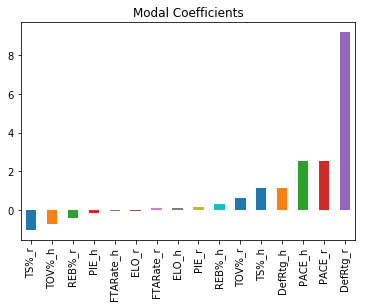

In [1076]:
coef.plot(kind='bar', title='Modal Coefficients')

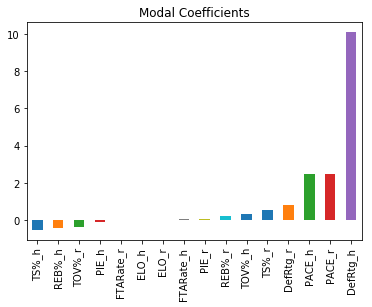

In [1077]:
predictors = X_train.columns
coef = pd.Series(roadBay.coef_,predictors).sort_values()
coef.plot(kind='bar', title='Modal Coefficients')

In [1079]:
coef.reset_index()

,index,0
0,TS%_h,-0.536554
1,REB%_h,-0.414643
2,TOV%_r,-0.399837
3,PIE_h,-0.127817
4,FTARate_r,-0.011060
5,ELO_h,0.011450
6,ELO_r,0.022057
7,FTARate_h,0.032793
8,PIE_r,0.071955
9,REB%_r,0.204341


In [33]:
bayHome_filename = "bay_rig_home_model.pkl"
bayRoad_filename = "bay_rig_road_model.pkl"
ardHome_filename = "ard_home_model.pkl"
ardRoad_filename = "ard_road_model.pkl"
huberHome_filename = "huber_home_model.pkl"
huberRoad_filename = "huber_road_model.pkl"
sgdHome_filename = "sgd_home_model.pkl"
sgdRoad_filename = "sgd_road_model.pkl"
theilHome_filename = "theil_sen_home_model.pkl"
theilRoad_filename = "theil_sen_road_model.pkl"
ransacHome_filename = "ransac_home_model.pkl"
ransacRoad_filename = "ransac_road_model.pkl"

bayHome_model = pickle.load(open(bayHome_filename, 'rb'))
bayRoad_model = pickle.load(open(bayRoad_filename, 'rb'))
ardHome_model = pickle.load(open(ardHome_filename, 'rb'))
ardRoad_model = pickle.load(open(ardRoad_filename, 'rb'))
huberHome_model = pickle.load(open(huberHome_filename, 'rb'))
huberRoad_model = pickle.load(open(huberRoad_filename, 'rb'))
sgdHome_model = pickle.load(open(sgdHome_filename, 'rb'))
sgdRoad_model = pickle.load(open(sgdRoad_filename, 'rb'))
theilHome_model = pickle.load(open(theilHome_filename, 'rb'))
theilRoad_model = pickle.load(open(theilRoad_filename, 'rb'))
ransacHome_model = pickle.load(open(ransacHome_filename, 'rb'))
ransacRoad_model = pickle.load(open(ransacRoad_filename, 'rb'))

In [70]:
model_dict = {'BayRidgeRegress': [bayRoad_model, bayHome_model],
              'ArdRegress': [ardRoad_model, ardHome_model] , 
              'HuberRegress': [huberRoad_model, huberHome_model] , 
              'SgdRegress': [sgdRoad_model, sgdHome_model], 
              'TheilSenRegress': [theilRoad_model, theilHome_model], 
              }

In [44]:
predictors = X_train.columns

In [69]:
ransacRoad_model.estimator_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [46]:
coef = pd.Series(bayRoad_model.coef_,predictors).sort_values()
coef.plot(kind='bar', title='Modal Coefficients')

In [48]:
coef = coef.reset_index()

In [50]:
coef.columns = ['Features', 'Coef']

In [51]:
coef

,Features,Coef
0,TS%_h,-0.536554
1,REB%_h,-0.414643
2,TOV%_r,-0.399837
3,PIE_h,-0.127817
4,FTARate_r,-0.011060
5,ELO_h,0.011450
6,ELO_r,0.022057
7,FTARate_h,0.032793
8,PIE_r,0.071955
9,REB%_r,0.204341


In [56]:
# export to json
items = coef.to_json(orient='columns', date_format='iso')
# load json string to json
items_db = json.loads(items)

In [59]:
items_db['Model'] = 'BayRidgeRegress'

In [60]:
items_db

{'Features': {'0': 'TS%_h',
  '1': 'REB%_h',
  '2': 'TOV%_r',
  '3': 'PIE_h',
  '4': 'FTARate_r',
  '5': 'ELO_h',
  '6': 'ELO_r',
  '7': 'FTARate_h',
  '8': 'PIE_r',
  '9': 'REB%_r',
  '10': 'TOV%_h',
  '11': 'TS%_r',
  '12': 'DefRtg_r',
  '13': 'PACE_h',
  '14': 'PACE_r',
  '15': 'DefRtg_h'},
 'Coef': {'0': -0.5365538064,
  '1': -0.414642889,
  '2': -0.3998369645,
  '3': -0.1278167583,
  '4': -0.0110601985,
  '5': 0.0114503285,
  '6': 0.0220568981,
  '7': 0.0327931194,
  '8': 0.0719552351,
  '9': 0.2043411445,
  '10': 0.2954661089,
  '11': 0.5293584858,
  '12': 0.8212196779,
  '13': 2.4955092713,
  '14': 2.4955092713,
  '15': 10.0906755532},
 'Model': 'BayRidgeRegress'}

In [73]:
def prepModelCoefDb(features, model_dict):
    model_list = []
    for key in model_dict.keys():
        mdl_r_h_dict = {}
        mdl_r = pd.Series(model_dict[key][0].coef_,features).sort_values()
        mdl_h = pd.Series(model_dict[key][1].coef_,features).sort_values()
        mdl_r = mdl_r.reset_index()
        mdl_r.columns = ['Features', 'Coef']
        mdl_h = mdl_h.reset_index()
        mdl_h.columns = ['Features', 'Coef']
        # export to json
        items = mdl_r.to_json(orient='columns', date_format='iso')
        # load json string to json
        items_db_r = json.loads(items)
        # export to json
        items = mdl_h.to_json(orient='columns', date_format='iso')
        # load json string to json
        items_db_h = json.loads(items)
        mdl_r_h_dict['Model'] = key
        mdl_r_h_dict['Params'] = {"Road": items_db_r, "Home" : items_db_h}
        model_list.append(mdl_r_h_dict)
    return model_list

In [81]:
mylist = prepModelCoefDb(predictors, model_dict)

In [85]:
db.score_pred_model_data.insert_many(mylist)

{'Model': 'Params'}

In [84]:
mylist

[{'Model': 'BayRidgeRegress',
  'Params': {'Road': {'Features': {'0': 'TS%_h',
     '1': 'REB%_h',
     '2': 'TOV%_r',
     '3': 'PIE_h',
     '4': 'FTARate_r',
     '5': 'ELO_h',
     '6': 'ELO_r',
     '7': 'FTARate_h',
     '8': 'PIE_r',
     '9': 'REB%_r',
     '10': 'TOV%_h',
     '11': 'TS%_r',
     '12': 'DefRtg_r',
     '13': 'PACE_h',
     '14': 'PACE_r',
     '15': 'DefRtg_h'},
    'Coef': {'0': -0.5365538064,
     '1': -0.414642889,
     '2': -0.3998369645,
     '3': -0.1278167583,
     '4': -0.0110601985,
     '5': 0.0114503285,
     '6': 0.0220568981,
     '7': 0.0327931194,
     '8': 0.0719552351,
     '9': 0.2043411445,
     '10': 0.2954661089,
     '11': 0.5293584858,
     '12': 0.8212196779,
     '13': 2.4955092713,
     '14': 2.4955092713,
     '15': 10.0906755532}},
   'Home': {'Features': {'0': 'TS%_r',
     '1': 'TOV%_h',
     '2': 'REB%_r',
     '3': 'PIE_h',
     '4': 'FTARate_h',
     '5': 'ELO_r',
     '6': 'FTARate_r',
     '7': 'ELO_h',
     '8': 'PIE_r',
   